### Imports

In [116]:
using DSP
using WAV
using Plots
using Polynomials

### Get test signal

In [117]:
function pre_emphasize(signal, alpha=0.95)
    filt_function = PolynomialRatio([1.0, -alpha], [1.0])
    return filt(filt_function, signal)
end

pre_emphasize (generic function with 2 methods)

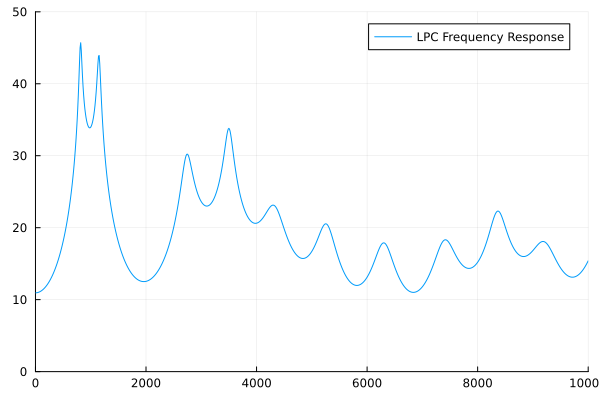

In [118]:
signal, fs, b, opt = wavread("demo_data/aa_audio/audio_lpc_aa_fo160.wav")
signal = signal[1:end]
signal1 = pre_emphasize(signal)
signal2 = pre_emphasize(signal1)
# signal3 = pre_emphasize(signal2)
order = 50
n = 2048
a, e = lpc(signal2, order)
a = vcat(1.0, a)
filt_func = PolynomialRatio([1.0], a)
f = [0:(fs/2)/n:fs/2;]
resp = freqz(filt_func, f, fs)
resp = 20*log10.(abs.(resp))
plot(f, resp, xlim=(0,10000), ylim=(0,50), label="LPC Frequency Response")

### Basic peak picking algorithm

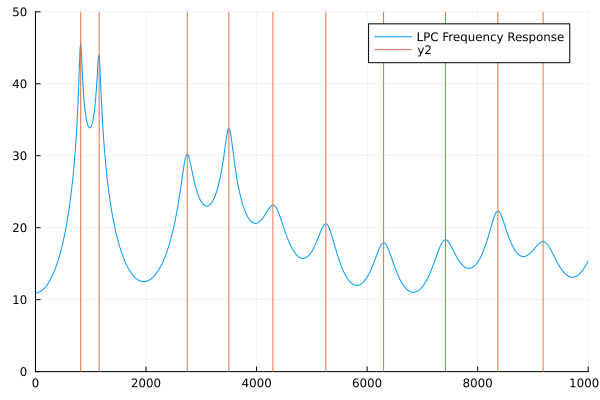

In [119]:
peaks = []
for i in [2:1:length(resp)-1;]
    prev = resp[i-1]
    cur = resp[i]
    next = resp[i+1]
    if cur > prev && cur > next
        push!(peaks, f[i])
    end
end
plot(f, resp, xlim=(0,10000), ylim=(0,50), label="LPC Frequency Response")
vline!(peaks)

### Peak picking algorithm with parabola fitting

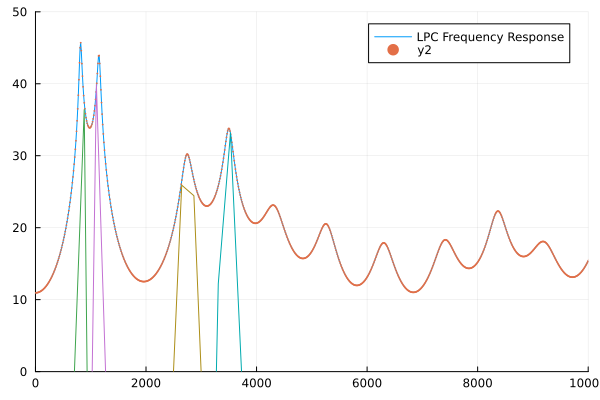

In [123]:
n_points = 5

peaks = []
parabolas = []

for i in [2:1:length(resp)-1;]
    prev = resp[i-1]
    cur = resp[i]
    next = resp[i+1]
    if cur > prev && cur > next
        # println(vcat(resp[i-n_points-1:i-1], resp[i+1:i+1+n_points]))
        quadfit = fit(vcat(f[i-n_points-1:i-1], f[i+1:i+1+n_points]), vcat(resp[i-n_points-1:i-1], resp[i+1:i+1+n_points]), 2)
        push!(peaks, f[i])
        push!(parabolas, quadfit)
    end
end

plot(f, resp, xlim=(0,10000), ylim=(0,50), label="LPC Frequency Response")
scatter!(f, resp, markerstrokewidth=0, markersize=1)
# vline!(peaks)
plot!(parabolas[1], f[1], f[end], label="")
plot!(parabolas[2], f[1], f[end], label="")
plot!(parabolas[3], f[1], f[end], label="")
plot!(parabolas[4], f[1], f[end], label="")

# for parabola in parabolas
#     plot!(parabola, f[1], f[end], label="")
# end